In [2]:
import numpy as np
import scipy.constants as const
from arc import *
import random

In [2]:
def trap_depth_gaussian(pol, P, wx, wy):
    """ trap depth for a focused gaussian beam
        pol: polarizability in units of Hz m^2/W
        P: power of the beam (W)
        wx: waist along x direction in m
        wy: waist along y direction in m
        return trap depth in Hz
    """
    I0_elliptical_xy= 2*P/ (np.pi* wx * wy) #multiply waists from um to cm such 
    U0_xy = - pol * I0_elliptical_xy/4 #in Hz. Divide by 4 because we used peak electric field in the calculation
                                    #of polarizability instead of rms.
    return U0_xy

mass_Rb = 87*const.u

### Sanity check: Tweezer
1.7 mW of 852nm focused on a round waist of 0.75 um, should yieald 1 mK trap depth

In [3]:
atom = Rubidium87()
calc = DynamicPolarizability(atom, atom.groundStateN, 0, 0.5)
calc.defineBasis(atom.groundStateN, atom.groundStateN+15)

alpha0_twz, alpha1_twz, alpha2_twz, core, dynamic, closestState = calc.getPolarizability(852e-9, units="SI", accountForStateLifetime=True)

tweez_polB_GS=2*alpha0_twz*1/(const.epsilon_0*const.speed_of_light) # units of Hz m^2/W. We consider only the scalar polarizability
print("Polarization of GS with 852nm = %.3e Hz m^2/W." % (tweez_polB_GS))
U0_tweezer = trap_depth_gaussian(tweez_polB_GS, 1.76e-3, 0.707e-6, 0.707e-6) #in Hz
print("Trap depth in uK: ", U0_tweezer*const.h/const.k*1e6)

Polarization of GS with 852nm = 3.884e-02 Hz m^2/W.
Trap depth in uK:  -1044.5188181367255


# Light assisted two body loss rate

In [4]:
def trap_volume(T0, omega_ax, omega_rad, mass=mass_Rb):
    """
    T0 initial temperature in K
    omega_ax (rad) axial (radial) trap fequencies
    return in m^3
    """
    omega = (omega_ax * omega_rad**2)**(1/3)
    return (2*pi*const.k*T0/ (mass* omega**2))**(3/2)

def calc_beta(gamma,V):
    """
    gamma is the fitted two-body loss decay rate. 
    V trap volume
    return in SI units m^3/s
    """
    return gamma * 2* np.sqrt(2) * V

## Monte-Carlo simulation

In [24]:
def dq_two_body(beta_prime, N, dt):
    return beta_prime * N*(N-1)*dt/2

def dq_one_body(gamma, N, dt):
    return gamma * N *dt

def P1(U, T0, alpha, t):
    """ Survival probability of an atom due to heating. Assuming a harmonic trap and a Boltzmann energy distribution
    U: trap depth in J
    T0 initial temperature
    alpha: heating rate"""
    eta= U/ (const.k *(T0 + alpha*t))
    return 1- (1+ eta + 1/2 * eta**2) * np.exp(-eta)

def number_of_lost_atoms(key_name):
    if key_name == 'no_loss':
            return 0 # no loss
    elif key_name== 'one_loss':
            return 1 # one loss
    elif key_name== 'two_loss':
            return 2 # two loss

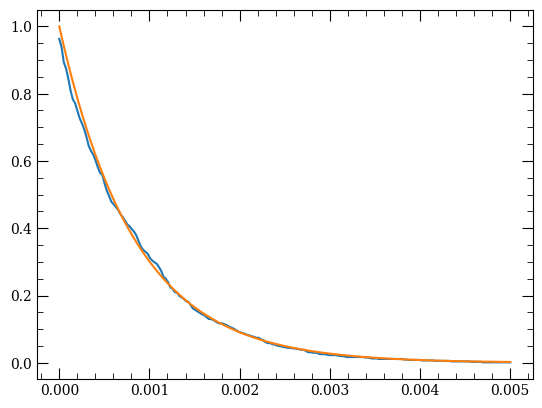

In [25]:
beta_prime = 1.2 *1e3 #atoms/ms
gamma = 0 #fitted 1 body loss decay rate
T= 15e-6
# tweezer_depth= abs(U0_tweezer_inJ)
trajectories = 700
ts = np.linspace(0, 5e-3, 200)
dt_step = ts[1]-ts[0]

surv_sum_traj = np.zeros(len(ts))
for j in np.arange(trajectories):
    N0= 2 # intial number of atoms
    surv_dts =np.zeros(len(ts))
    surv_dts[0]= N0 
    for i in range(len(ts)):
        if (i==0):
            num_atoms_at_this_step = surv_dts[0]
        else:
            num_atoms_at_this_step = surv_dts[i-1]

        P_two_body_loss = dq_two_body(beta_prime, num_atoms_at_this_step, dt_step)
        # P_one_body_loss= 0 # assuming no one body loss for now
        P_one_body_loss= dq_one_body(gamma, num_atoms_at_this_step, dt_step)

        prob_no_loss = (1-P_one_body_loss)*(1-P_two_body_loss)
        prob_one_loss = P_one_body_loss*(1-P_two_body_loss)
        prob_two_loss = (1-P_one_body_loss)*P_two_body_loss

        prob_dict= {'no_loss': prob_no_loss, 'one_loss': prob_one_loss, 'two_loss': prob_two_loss }
        #define a probability order
        ordered_dict = (sorted(prob_dict.items(), key=lambda x:x[1])) # returns an ordered array, ordered by the probability value. eg. [('one_loss', 1), ('no_loss', 2), ('two_loss', 4)]

        #now we choose which decay channel will happen using Monte Carlo
        p_rand = random.random() 

        if p_rand < ordered_dict[0][1]: 
                surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[0][0])
        elif p_rand > ordered_dict[0][1] and p_rand < ordered_dict[1][1] : 
                surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[1][0])
        elif p_rand > ordered_dict[1][1]: 
                surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[2][0])
    
    #in theory this should be it. however in our experiment we apply a 2->1 collision if we still have two atoms at the end.
    for k in range(len(surv_dts)):
          if surv_dts[k] ==2:
                surv_dts[k] -= 1

    surv_sum_traj += surv_dts

surv_average = surv_sum_traj/ trajectories

plt.plot(ts, surv_average)
plt.plot(ts, np.exp(-ts*beta_prime))


In [72]:
a= np.arange(3)
a[-1]

2

## Antoine numbers (Fuhrmanek, PHYSICAL REVIEW A 85, 062708 (2012))

In [7]:
T0_paris= 300e-6 # 200 uK
omega_ax_paris = 2*pi* 25e3 # 2pi x 25 kHz
omega_rad_paris = 2*pi* 130e3 # 2pi x 130 kHz
volume_paris = trap_volume(T0_paris, omega_ax_paris,omega_rad_paris) 
print("Trap volume: "+str(round(volume_paris * (1e6)**3, 2)) +" um^3. From paper expect 0.7 um^3")

Trap volume: 0.73 um^3. From paper expect 0.7 um^3


In [8]:
beta_prime_paris = 1.2 *1e3 # atoms/s in the paper 1.2 atoms/ms
beta_paris= calc_beta(beta_prime_paris, volume_paris)
print("Beta: "+str(round(beta_paris* (1e2)**3,11)) +" cm^3/s. From paper 2.4e-9 cm^3/s" )

Beta: 2.48e-09 cm^3/s. From paper 2.4e-9 cm^3/s


## Our numbers

### Tweezer parameters

In [78]:
lambda_l= 850e-9 
k_l = 2*np.pi/lambda_l
P= 1.5e-3; wx = 0.7e-6; wy= wx

atom = Rubidium87()
calc = DynamicPolarizability(atom, atom.groundStateN, 0, 0.5)
calc.defineBasis(atom.groundStateN, atom.groundStateN+15)
alpha0_twz, alpha1_twz, alpha2_twz, core, dynamic, closestState = calc.getPolarizability(lambda_l, units="SI", accountForStateLifetime=True)

tweez_polB_GS=2*alpha0_twz*1/(const.epsilon_0*const.speed_of_light) # units of Hz m^2/W. We consider only the scalar polarizability
print("Polarizability of GS with 850nm = %.3e Hz m^2/W." % (tweez_polB_GS))
U0_tweezer = trap_depth_gaussian(tweez_polB_GS, P, wx, wy) #in Hz
U0_tweezer_inJ = U0_tweezer*const.h
U0_tweezer_inK = abs(U0_tweezer*const.h/const.k)
print("Trap depth in uK: ", abs(U0_tweezer*const.h/const.k*1e6))

mass_Rb = 87*const.u
zr= np.pi * wx**2/ lambda_l
omega_parallel= np.sqrt(2* abs(U0_tweezer_inJ)/ (mass_Rb* zr**2))/ (2* np.pi)
omega_perpendicular= np.sqrt(4* abs(U0_tweezer_inJ)/ (mass_Rb* wx**2))/ (2* np.pi)
print("Trap frequency parallel: "+ str(omega_parallel/1e3)+ " kHz")
print("Trap frequency perpendicular: "+ str(omega_perpendicular/1e3)+ " kHz")

Polarizability of GS with 850nm = 3.993e-02 Hz m^2/W.
Trap depth in uK:  933.5809029329741
Trap frequency parallel: 37.12287033435295 kHz
Trap frequency perpendicular: 135.82682006679235 kHz


### 2->0 collisions

In [77]:
T0 =30e-6
omega_ax = 2*pi* 35.44e3 # 2pi x 25 kHz
omega_rad = 2*pi* 129.6e3 # 2pi x 130 kHz
volume = trap_volume(T0, omega_ax,omega_rad) 
print("Trap volume: "+str(round(volume * (1e6)**3, 3)) +" um^3")

beta_prime = 30 *1e3 # atoms/s in the paper 1.2 atoms/ms
beta= calc_beta(beta_prime, volume)
print("Beta: "+str(beta* (1e2)**3) +" cm^3/s" )

Trap volume: 0.016 um^3
Beta: 1.3894630765388815e-09 cm^3/s


# Linear Heating: no cooling for atom in tweezers

Here we assume to have an atom trapped in single tweezer that is not cooled. Following the thesis Scaling-up the Tweezer Platform - Trapping Arrays of Single Atoms in a Cryogenic Environment from Schymik

In [103]:
# lambda_l= 826e-9 
#P= 1.0e-3; wx = 0.75e-6; wy= 0.75e-6
lambda_l= 850e-9 
k_l = 2*np.pi/lambda_l
P= 1.8e-3; wx = 0.73e-6; wy= wx

# P= 0.3*1.45e-3; wx = 0.73e-6; wy= wx


atom = Rubidium87()
calc = DynamicPolarizability(atom, atom.groundStateN, 0, 0.5)
calc.defineBasis(atom.groundStateN, atom.groundStateN+15)
alpha0_twz, alpha1_twz, alpha2_twz, core, dynamic, closestState = calc.getPolarizability(lambda_l, units="SI", accountForStateLifetime=True)

tweez_polB_GS=2*alpha0_twz*1/(const.epsilon_0*const.speed_of_light) # units of Hz m^2/W. We consider only the scalar polarizability
print("Polarizability of GS with 826nm = %.3e Hz m^2/W." % (tweez_polB_GS))
U0_tweezer = trap_depth_gaussian(tweez_polB_GS, P, wx, wy) #in Hz
U0_tweezer_inJ = U0_tweezer*const.h
U0_tweezer_inK = abs(U0_tweezer*const.h/const.k)
print("Trap depth in uK: ", abs(U0_tweezer*const.h/const.k*1e6))

mass_Rb = 87*const.u
zr= np.pi * wx**2/ lambda_l
omega_parallel= np.sqrt(2* abs(U0_tweezer_inJ)/ (mass_Rb* zr**2))/ (2* np.pi)
omega_perpendicular= np.sqrt(4* abs(U0_tweezer_inJ)/ (mass_Rb* wx**2))/ (2* np.pi)
print("Trap frequency parallel: "+ str(omega_parallel/1e3)+ " kHz")
print("Trap frequency perpendicular: "+ str(omega_perpendicular/1e3)+ " kHz")


Polarizability of GS with 826nm = 3.993e-02 Hz m^2/W.
Trap depth in uK:  1030.1099097853044
Trap frequency parallel: 35.85565918272112 kHz
Trap frequency perpendicular: 136.81273221895654 kHz


Scattering rate: 7.3 s^-1
linaear heating rate: 2.23 uK/s


In [6]:
def P_survival_lin_heating(t, tau, alpha, U0= U0_tweezer_inK, T0=20e-6):
    P_vacuum = np.exp(-t/tau)
    P_heat = 1- np.exp(- U0/(T0 + alpha*t) ) * ( 1+ U0/(T0 + alpha*t) + U0**2/(2*(T0 + alpha*t)**2) )
    return P_vacuum*P_heat

Text(0.5, 1.0, 'lifetime: tau= 100 s, alpha = 137 uK s^-1')

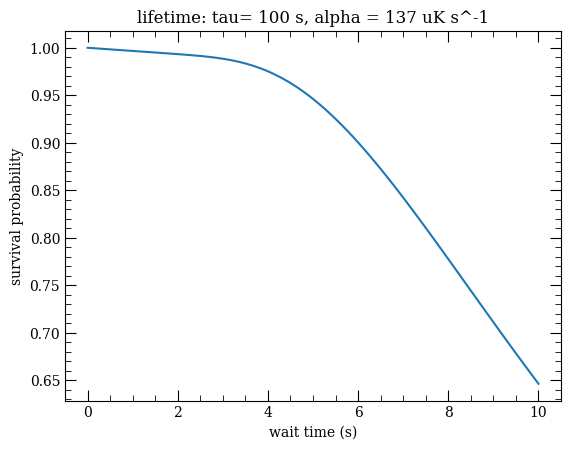

In [7]:
time= np.linspace(0,10, 100)
fig,ax = plt.subplots()
ax.plot(time,P_survival_lin_heating(time, 300, 30e-6, U0=U0_tweezer_inK, T0=10e-6) )
# ax.set_yscale('log')
ax.set_xlabel( "wait time (s)")
ax.set_ylabel("survival probability")
ax.set_title("lifetime: tau= 100 s, alpha = 137 uK s^-1")

# Monte-Carlo simulations: release-recapture

Following the procedure discussed in Tuchendler et al., 2008 Energy distribution and cooling of a single atom in an optical tweezer.

For the simulation, the initial position and velocity are chosen according to normal distributions with widths σr,v, and we consider that an atom is lost if its kinetic energy is higher than the trap potential at the atom position after the time of flight.

In [8]:
def delta_x_par (T, omega_par, mass= 87*const.u):
    return np.sqrt(const.k*T / (mass * omega_par**2) )

def delta_x_perp (T, omega_perp, mass= 87*const.u):
    return np.sqrt(const.k*T / (mass * omega_perp**2) )

def delta_v (T, mass= 87*const.u):
    return np.sqrt(const.k * T/ mass)

def get_initial_params(T, omega_par, omega_perp):
    # in here we assume that the z direction is the tweezer axis -> omega parallel
    (xi, yi)= np.random.normal(0, delta_x_perp(T, omega_perp), 2)
    zi= np.random.normal(0, delta_x_par(T, omega_par))
    (vxi, vyi, vzi) = np.random.normal(0, delta_v(T), 3)
    return (xi, yi, zi, vxi, vyi, vzi)

def get_final_params(dt, xi,yi,zi, vxi, vyi, vzi):
    g= 9.8 # m/s
    xf = xi + vxi*dt
    yf = yi + vyi*dt - (g * dt**2)/2
    zf = zi + vzi*dt
    vxf = vxi
    vyf = vyi - g*dt
    vzf = vzi

    return (xf, yf, zf, vxf, vyf, vzf )

def get_final_K_energy (xf, yf, zf, vxf, vyf, vzf, omega_par, omega_perp, mass = 87*const.u):
    return mass/2 * (vxf**2 + vyf**2 + vzf**2) + 1/2 * mass * ( (omega_par**2 * zf**2) + omega_perp**2 * (xf**2+ yf**2))



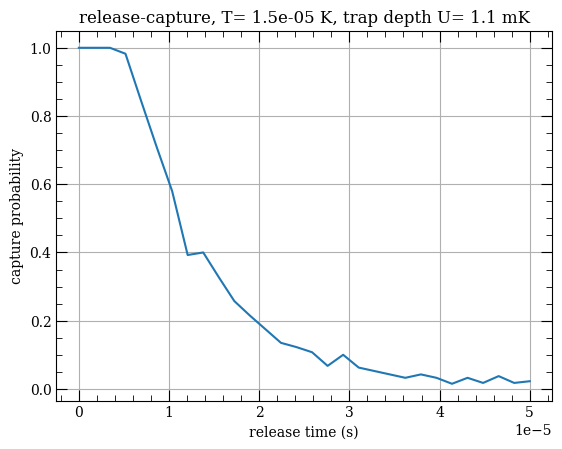

In [9]:
T= 15e-6
tweezer_depth= abs(U0_tweezer_inJ)
# tweezer_depth= const.k *1.25e-3

trajectories_per_time = 400
dts = np.linspace(0, 50e-6, 30)

surv_dts =np.zeros(len(dts))

for j in range(len(dts)):
    dt = dts[j]
    surv1 = np.zeros(trajectories_per_time)
    for i in range(trajectories_per_time):
        initial_params = get_initial_params(T, omega_par= 2*pi*omega_parallel, omega_perp= 2*pi*omega_perpendicular)
        final_params = get_final_params(dt, *initial_params)
        final_K_energy= get_final_K_energy(*final_params, omega_par= 2*pi*omega_parallel, omega_perp= 2*pi*omega_perpendicular)
        # print(final_K_energy)
        if (final_K_energy < tweezer_depth):
            surv1[i]+=1
    surv_dts[j] = surv1.mean()

fig,ax = plt.subplots()
ax.plot(dts, surv_dts)
ax.set_ylabel ("capture probability")
ax.set_xlabel ("release time (s)")
ax.set_title("release-capture, T= "+str(T)+" K, trap depth U= " + str(round(abs(U0_tweezer*const.h/const.k*1e3), 1))+" mK"  )
ax.grid()
        

In [10]:
final_params

(-3.0667869397460024e-06,
 -2.9974404437249587e-06,
 8.91106603848814e-07,
 -0.06026108094238013,
 -0.058356305740611805,
 0.017617406195244104)

In [12]:
mass_Rb = 87*const.u

(((const.h * 1/780e-9)**2/(2*mass_Rb))/const.k)*2000

0.0003618022144864041

In [13]:
2000/(2*pi*1e6)

0.0003183098861837907

/var/folders/jl/hvyntvy9231cvzp80j5b6wrm0000gn/T/ipykernel_22497/686729322.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1- np.exp(- U0/(T0) ) * ( 1+ U0/(T0 ) + U0**2/(2*(T0)**2) )
/var/folders/jl/hvyntvy9231cvzp80j5b6wrm0000gn/T/ipykernel_22497/686729322.py:4: RuntimeWarning: invalid value encountered in multiply
  return 1- np.exp(- U0/(T0) ) * ( 1+ U0/(T0 ) + U0**2/(2*(T0)**2) )


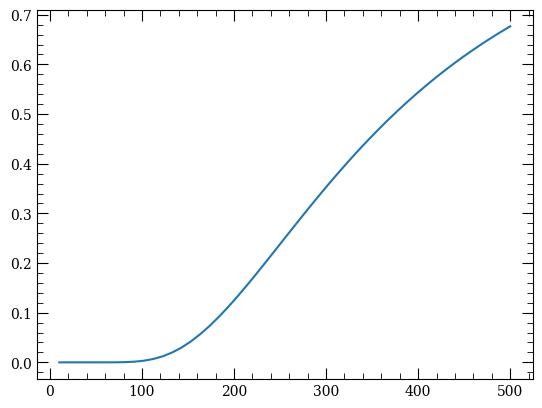

In [16]:
U0= 1e-3

def evaportation (T0):
    return 1- np.exp(- U0/(T0) ) * ( 1+ U0/(T0 ) + U0**2/(2*(T0)**2) )

temps= np.linspace(0, 500e-6)
plt.plot(temps*1e6, 1-evaportation(temps))